# Keypoint regression with heat maps in fastai v2

**If you want to avoid reading the lengthy intro, just skip ahead to the Data section, you won't _necessarily_ miss anything.**

A common task in computer vision is finding points of interest in images. For instance, think about locating the position of facial features or joint positions, or locating a set of keys in a picture of your living room (I'm not aware of anybody having built this, but they should). There's a [tutorial in the fastai documentation](https://docs.fast.ai/tutorial.vision.html#Points) showing a quick way to create a keypoint regressor using a convolutional neural net. The way this works is simple: take a pretrained network, and slap a linear layer at the end that predicts $(x,y)$ coordinates for the number of points that you're interested in.

While this approach may have decent results, you might find that the average error can really be quite bad. The reason for this [can be found in the literature](https://arxiv.org/abs/1411.5752) and is intuitively understood as follows: a deep convolutional neural net will generally learn more semantically complex features as it gets deeper into the network, but it will lose spatial accuracy. What that means is that the early layers will be able to activate on simple geometries (i.e. "vertical line") whereas the later layers activate on more complex concepts composed of these geometries (i.e. "fur" or "foot"). If you are training a classifier, having semantically rich features is necessary and sufficient for the task ("human foot" plus "knee" plus "chest" equals high probability of the class "person"), but for precise localization of specific points in the input image, a higher resolution is typically required. For accurate prediction we do however also need the broader context (locating a knee will be much more accurate if we can takethe position of a foot into account), so we cannot simply use fewer and simpler layers. The challenge then becomes to create network that can predict semantically rich features without losing spatial accuracy.

Several approaches have been developed to combat this problem, an good overview in the field of human pose estimation can be foun [in this post](https://nanonets.com/blog/human-pose-estimation-2d-guide/). A common approach is to not predict points directly, but rather predict a _heat map_ of point locations for each point of interest. For instance, let's assume we want to predict the nose and eyes in a `256x256` picture of a face, the output of our network will be a $3xWxH$ tensor, with each channel respresenting one of our points of interest, and each pixel representing the likelihood of that pixel being the location we're looking for. To retrieve the output pixel value, we simply find the pixel with the highest activation in each output heat map, and scale its coordinate back up to the original. As prediction targets we generate $3xWxH$ reference images that are filled with mostly zeroes, but have Gaussian kernels centered around the location of the keypoints. The use of Gaussian kernels introduces a wider range of "correct" answers and makes it less likely that the model will have a better score by simply predicting all zeros.

With that, our task has suddenly become a lot like another task: semantic segmentation. Indeed, similar U-Net style networks have been successfully employed for this task. In this blog post I will be looking at how we can achieve this heat map regression using vanilla fastai v2. 

As a bonus I'm going look into reducing the rounding error by implementing [Heatmap Regression via Randomized Rounding](https://arxiv.org/abs/2009.00225), something I'll do using a [HRNet](https://arxiv.org/pdf/1902.09212.pdf) architecture - a state of the art architecture when it comes to human pose estimation.

In [606]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [461]:
# Some debugging convenience. If you use trace() in a loop,
# you can turn it off temporarily using trace_off()
from IPython.core.debugger import set_trace
trace = set_trace
def enable_trace(enable=True):
    global trace
    trace = set_trace if enable else lambda: 1

def trace_off(): enable_trace(False)
def trace_on(): enable_trace(True)

# Data
I'll be using the [LaPa](https://github.com/JDAI-CV/lapa-dataset) dataset in this post. This dataset consists of 44000+ images of faces, with 106 facial landmarks annotated in each image. The dataset has already been split into training, validation and test sets. Let's start by downloading the dataset. There's a Google Drive link on the GitHub page of the dataset. Unfortunately Google Drive puts an annoying warning page in front of files larger than 25mb, so we can't create a direct file URL, but we can use a utility called `gdown` to download the file for us (use `!pip install gdown` if it hasn't been installed already). Let's download and extract the dataset (it's 2.4Gb, so have some patience and disk space):

In [607]:
# LaPa
import gdown
lapa='https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG'
gdown.download(lapa, 'lapa.tgz')
file_extract('lapa.tgz', '.')

Downloading...
From: https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
To: /Users/elte/Documents/SRXP/point-prediction-post/lapa.tgz
2.37GB [03:25, 11.5MB/s]


Now let's load fastai and import the dataset.

In [608]:
from fastai.vision.all import *
import os
lapa_path = Path('LaPa')

In [609]:
lapa_path.ls()

(#3) [Path('LaPa/test'),Path('LaPa/train'),Path('LaPa/val')]

There's a `test`, `train` and a `val` path, with each the same structure:

In [611]:
lapa_path.ls()[0].ls()

(#3) [Path('LaPa/test/images'),Path('LaPa/test/labels'),Path('LaPa/test/landmarks')]

For each file in `images`, there's a text file in `landmarks` that contains the annotated location of the facial landmarks. In addition there's a segmentation mask in `labels` - we want to ignore these, so we'll have to make sure to not load _all_ image files. The images have varying sizes, so we'll have to resize them. The landmark text files contain lists of `x,y` locations of features. This gives us enough information to create a `DataBlock`:

In [666]:
Resize??

In [667]:
# The input size we'll be using throughout this notebook
SIZE=(256,256)

def get_lapa_images(path):
    return get_files(path, extensions=set(['.jpg']))

def lapa_y(f, lm_idx=None):
    base=os.path.splitext(os.path.basename(f))[0]
    landmarks=f.parents[1]/'landmarks'/(f'{base}.txt')
    with open(landmarks, 'r') as f:
        # The first line of each landmarks file indicates the
        # number of landmarks and can be skipped.
        points = [[float(x) for x in line.strip().split()]
                    for line in f.readlines()[1:]]
    
    points = tensor(points)
    
    if lm_idx:
        points = points[lm_idx, :]
    
    return points

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_lapa_images,
    get_y=lapa_y,
    item_tfms=Resize(SIZE),
    # We're leaving "test" alone for now
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

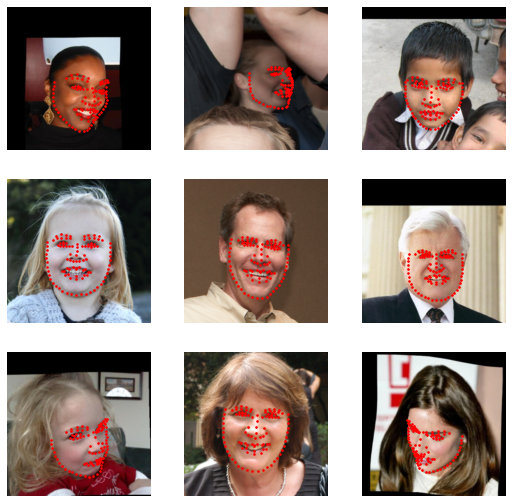

In [668]:
dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=9)

Looks good! To make things a bit easier in this post, I'm going to focus on 6 out of 106 facial landmarks. Let's redefine the datablock to limit the landmarks, and add some transforms in the process. We'll normalize with ImageNet stats, because we'll be using a model pretrained on ImageNet soon. The reason I'm not allowing the transform to flip images is that some of the annotated points on these faces are symmetric (well, maybe not the points I've selected, but in general), and I don't want to deal with mirrorred predictions.

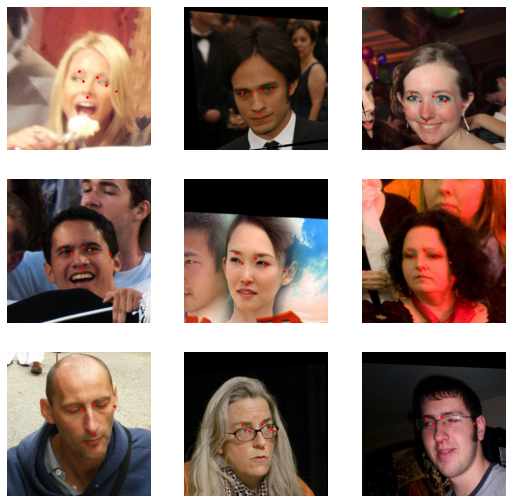

In [669]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_lapa_images,
    get_y=partial(lapa_y, lm_idx=[30, 40, 50, 60, 70, 80]),
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), Normalize.from_stats(*imagenet_stats)],
    # We're leaving "test" alone for now
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=9)

That looks good. Now for the more difficult part.

## Gaussian Heatmaps

The first step to creating our heatmaps is creating a function that... well, generates a heat map. Let's define a function `generate_gaussian()` that takes a tensor and an `(x,y)` location, and generates a Gaussian kernel with a certain standard deviation at the given point. The credit for large parts of this code goes to one of the [repositories](https://github.com/leoxiaobin/deep-high-resolution-net.pytorch/blob/ba50a82dce412df97f088c572d86d7977753bf74/lib/dataset/JointsDataset.py#L242) of the model we're about to use.



<AxesSubplot:>

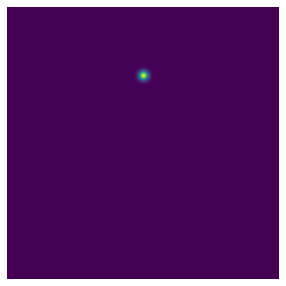

In [648]:
# A gaussian kernel cache, so we don't have to regenerate them every time.
# This is only a small optimization, generating the kernels is pretty fast.
_gaussians = {}

def generate_gaussian(t, x, y, sigma=3):
    """
    Generates a 2D Gaussian point at location x,y in tensor t.
    
    x should be in range (-1, 1) to match the output of fastai's PointScaler.
    
    sigma is the standard deviation of the generated 2D Gaussian.
    """
    h,w = t.shape
    
    # Heatmap pixel per output pixel
    mu_x = int(0.5 * (x + 1.) * w)
    mu_y = int(0.5 * (y + 1.) * h)
    
    tmp_size = sigma * 3
    
    # Top-left
    x1,y1 = int(mu_x - tmp_size), int(mu_y - tmp_size)
    
    # Bottom right
    x2, y2 = int(mu_x + tmp_size + 1), int(mu_y + tmp_size + 1)
    if x1 >= w or y1 >= h or x2 < 0 or y2 < 0:
        return t
    
    size = 2 * tmp_size + 1
    tx = np.arange(0, size, 1, np.float32)
    ty = tx[:, np.newaxis]
    x0 = y0 = size // 2
    
    # The gaussian is not normalized, we want the center value to equal 1
    g = _gaussians[sigma] if sigma in _gaussians \
                else tensor(np.exp(- ((tx - x0) ** 2 + (ty - y0) ** 2) / (2 * sigma ** 2)))
    _gaussians[sigma] = g
    
    # Determine the bounds of the source gaussian
    g_x_min, g_x_max = max(0, -x1), min(x2, w) - x1
    g_y_min, g_y_max = max(0, -y1), min(y2, h) - y1
    
    # Image range
    img_x_min, img_x_max = max(0, x1), min(x2, w)
    img_y_min, img_y_max = max(0, y1), min(y2, h)
    
    t[img_y_min:img_y_max, img_x_min:img_x_max] = \
      g[g_y_min:g_y_max, g_x_min:g_x_max]
    
    return t

# Example:
show_image(generate_gaussian(torch.zeros(256, 256), 0, -0.5))

Alright, that's looking pretty good. Next, we need a way to actually _use_ these heatmaps. There are multiple approaches here. We could simply take our dataset, and create the heatmap stacks for each item in it. The advantage of this is that we'd have to create our heatmaps only once. There is a downside though: none of fastai's bundled data augmentation techniques work on our custom heatmaps, so we'd either have to reimplement those ourselves (which seems like a lot of work) or just not use them altogether (which doesn't seem all that great either). Instead - what if we implemented the heatmap as a `Transform`, and applied it at the end? That way, fastai's data augmentation techniques can go to town on the `TensorPoint` instances, and in the very last step we convert them to heatmaps for prediction. So that's what we're going to do below:

In [653]:
import itertools

class Heatmap(TensorImageBase): 
    "Heatmap tensor, we can use the type to modify how we display things"
    pass

class HeatmapPoint(TensorPoint):
    """
    A class that mimics TensorPoint, but wraps it so
    we'll be able to override `show` methods with
    a different type.
    """
    pass

def _scale(p, s): return 2 * (p / s) - 1

class HeatmapTransform(Transform):
    """
    A batch transform that turns TensorPoint instances into Heatmap instances.
    
    Used as the last transform after all other transformations. 
    Note that upon decoding, we actually return HeatmapPoint
    instances, which allows us to specifically override result showing methods.
    """
    # We want the heat map transformation to happen last, so give it a high order value
    order=999
    
    def __init__(self, heatmap_size, sigma=3, **kwargs):
        super().__init__(**kwargs)
        self.sigma = sigma
        self.size = heatmap_size
    
    def encodes(self, x:TensorPoint):
        # The shape of x is (batch x n_points x 2)
        num_imgs = x.shape[0]
        num_points = x.shape[1]
        
        maps = Heatmap(torch.zeros(num_imgs, num_points, *self.size))
        for b,c in itertools.product(range(num_imgs), range(num_points)):
            # Note that our point is already scaled to (-1, 1) by PointScaler
            point = x[b][c]
            generate_gaussian(maps[b][c], point[0], point[1], sigma=self.sigma)
        
        return maps
    
    def decodes(self, x:Heatmap):
        """
        Decodes a heat map back into a set of points by finding
        the coordinates of their argmax.
        
        This returns a HeatmapPoint class rather than a TensorPoint
        class, so we can modify how we display the output.
        """
        # Flatten the points along the final axis,
        # and find the argmax per channel
        m1 = x.view(x.shape[0], x.shape[1], -1).argmax(dim=2)
        
        # The flattened index f of point (y, x) is y * width + x,
        # so in order to get x we do f % width, and in order to
        # get y we do f // width. We scale the points to (-1, 1)
        x_idx = _scale(m1 % x.shape[3], x.shape[3])
        y_idx = _scale(m1 // x.shape[3], x.shape[2])
        
        # Stack the points to get a list of coordinates per image
        pts = torch.stack([x_idx, y_idx], dim=2)
        
        # Turn into a HeatmapPoint tensor. Note that we pass in x
        # as metadata, so we can still display the heatmaps when
        # showing results.
        return HeatmapPoint(pts, source_heatmap=x)

I should mention that this is a bit of a hack, fastai will actually attempt to retain the specific subclass of the tensor after each transform. Since `Heatmap` cannot be downcasted to `TensorPoint` it comes out as itself just fine in this case. Note also that these classes accept a flexible number of points, o we can let them create as many heat maps as we want.

Alright, let's see what it looks like if we use the exact same code as before, but now we add our `HeatmapTransform` at the end:

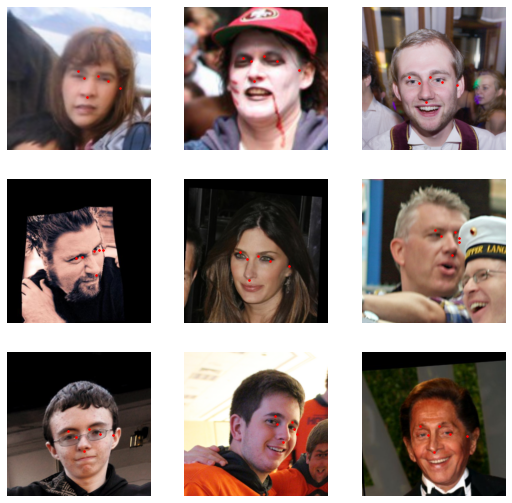

In [659]:
dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_lapa_images,
    get_y=partial(lapa_y, lm_idx=[30, 40, 50, 60, 70, 80]),
    item_tfms=Resize(400),
    batch_tfms=[*aug_transforms(size=SIZE, do_flip=False), 
                Normalize.from_stats(*imagenet_stats),
                HeatmapTransform(heatmap_size=SIZE)],
    # We're leaving "test" alone for now
    splitter=GrandparentSplitter(train_name='train', valid_name='val')
)

dls = dblock.dataloaders(lapa_path)
dls.show_batch(max_n=9)

That looks... identical. This is good, because it means that our points are successfully converted to a heatmap and then back to the original point when they are displayed. However, when our predictions come in, we probably want to display the heat maps as well as the predicted points, so we can analyze issues in our training. Let's start by overriding `show_batch()` for our `HeatmapPoint`s:

In [664]:
@typedispatch
def show_batch(x:TensorImage, y:HeatmapPoint, samples, ctxs=None, 
               max_n=10, nrows=None, ncols=None, figsize=None, **kwargs):
    """
    Custom show_batch for a TensorImage / Heatmap pair, that shows
    the predicted points as well as the heat maps. Note that this method ignores
    nrows / ncols entirely.
    """
    # x is a list of TensorImages
    # y is a list of Heatmaps
    # samples is a list of (TensorImage, HeatmapPoint) tuples
    
    # Number of items to display
    n = min(len(samples), max_n)
    
    # Could also get this from the number of points
    n_heatmaps = y[0].shape[0]
    
    cols = 1 + n_heatmaps
    
    if ctxs is None:
        ctxs = get_grid(cols * n, nrows=n, ncols=cols, figsize=figsize)
    
    # Show the image overlaid with the points
    for ctx,sample,_ in zip(ctxs[0::cols], samples, range(n)):
        sample[0].show(ctx=ctx, **kwargs)
        sample[1].show(ctx=ctx, **kwargs)
    
    # Show the individual heatmaps
    heatmaps = y.source_heatmap
    for i in range(n_heatmaps):
        # I'd add the `y` to the `zip`, but it's upcasted
        # to a tensor when iterated (but not when indexed)
        ctxs[i+1::cols] = [heatmaps[j][i].show(ctx=ctx, cmap='viridis', vmin=0, vmax=1, **kwargs) 
                           for ctx,j in zip(ctxs[i+1::cols], range(n))]
    
    return ctxs

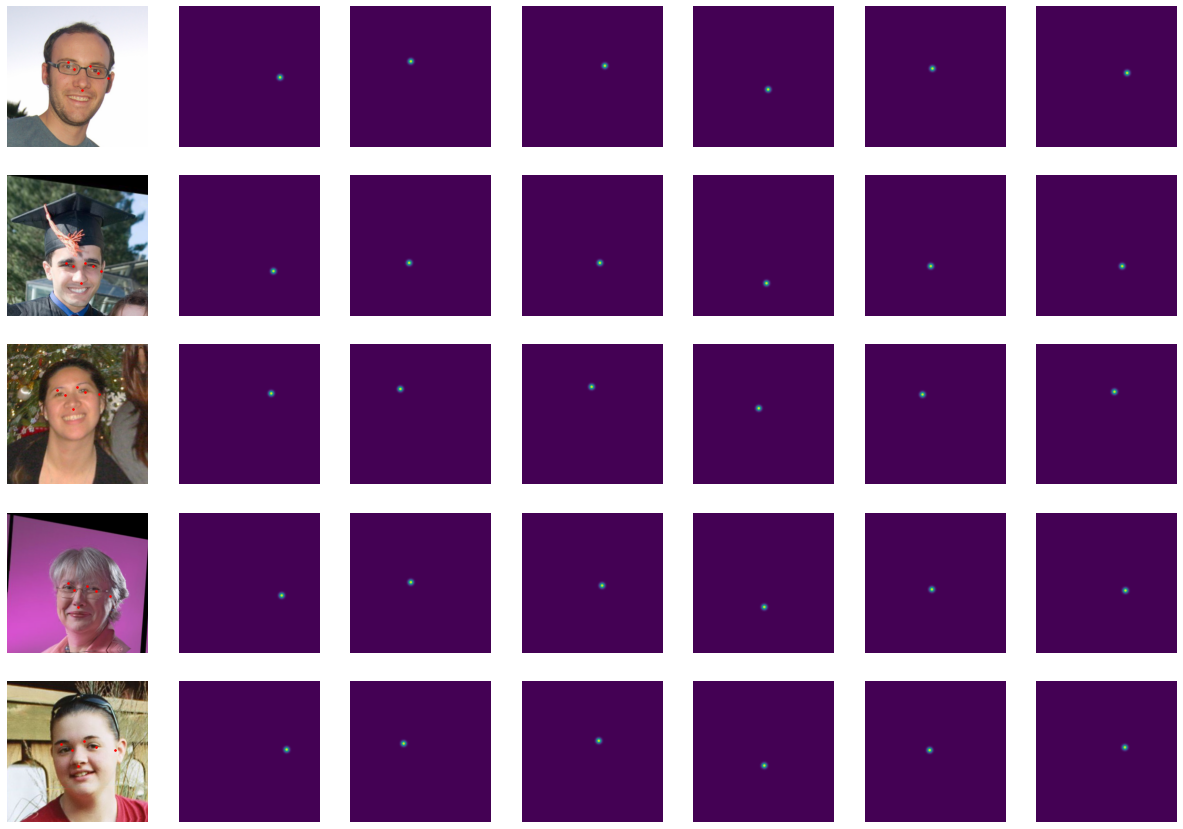

In [665]:
dls.show_batch(max_n=5)

Great! With that out of the way, we can simply use standard fastai to train a "segmentation" model.

## Training a UNet
Before we create our learner, let's define the metric we want to show to evaluate our training and results. We'll use Normalized Mean Absolute Error, which is the percentual absolute error of each coordinate from its target.

In [ ]:
def nmae(preds, targs):
    (inp-targ).abs()

# The model
At this point we could start training a unet-style learner based on this data in a few lines of code, but I instead want to take it one step further and use a state of the art model called HigherHRNet (yes, that's Higher High Resolution Net). What makes this model special, is that instead of running just a down sampling path (like a typical deep CNN) or running a downsampling path followed by an upsampling path (UNET-style) it maintains a high resolution path every step of the way. In essence, each layer contains features at multiple resolutions that are summed at the end (after pooling to equal sizes). 

PyTorch code for this model can be found [here](https://github.com/HRNet/HRNet-Facial-Landmark-Detection), and that repository also contains links to further explanations of the model as well as the paper that introduced it.

To use the model we don't need much more than the model file itself, and some configuration options. Let's start by downloading the model file from GitHub using a fastai utility function, and import it:

In [243]:
download_url("https://raw.githubusercontent.com/HRNet/HRNet-Facial-Landmark-Detection/master/lib/models/hrnet.py", "hrnet.py")

In [318]:
from hrnet import get_face_alignment_net

The `get_face_alignment_net` function takes a `cfg` argument, which is some configuration format contained within the repo. It contains some stuff we don't need, but it's easiest just to download it as well:

In [245]:
download_url("https://github.com/HRNet/HRNet-Facial-Landmark-Detection/raw/master/lib/config/defaults.py", "hrnet_config.py")

Note that the configuration format needs a library called `yacs` (you dan just `pip install yacs` if you don't have it). I'm hacking around a bit here importing an underscored name, but it's quicker and easier than copying in the entire repository.

In [319]:
from hrnet_config import _C as cfg

# This is the number of output planes that will be predicted
cfg.MODEL.NUM_JOINTS = 1



In [316]:
cfg.MODEL.EXTRA.STAGE3.NUM_MODULES=1
cfg.MODEL.EXTRA.STAGE4.NUM_MODULES=1
cfg.MODEL.EXTRA.STAGE4.NUM_CHANNELS=[18,32,72,144]

# cfg.MODEL.EXTRA.STAGE3.NUM_MODULES=4
# cfg.MODEL.EXTRA.STAGE4.NUM_MODULES=3
cfg.MODEL.EXTRA.STAGE4.NUM_CHANNELS=[18,36,72,144]

In [320]:
net=get_face_alignment_net(cfg)
example = torch.rand(5, 3, *SIZE)
net.eval()(example).shape

#############
[torch.Size([5, 18, 60, 80]), torch.Size([5, 36, 30, 40]), torch.Size([5, 72, 15, 20]), torch.Size([5, 144, 8, 10])]
#############
#### CAT: torch.Size([5, 270, 60, 80])


torch.Size([5, 1, 60, 80])

In [321]:
net.head

Sequential(
  (0): Conv2d(270, 270, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(270, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(270, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [312]:
tst = nn.Sequential(net.conv1, net.bn1, net.relu, net.conv2, net.bn2, net.relu, net.layer1)
tst(example).shape

torch.Size([5, 256, 60, 80])

# Scratch

In [467]:
download_url("https://raw.githubusercontent.com/baoshengyu/H3R/master/torchalign/backbone/hrnet.py", "hrnet.py")

In [482]:
tst = tensor([-1000, -1000, -1000, 0.2, 1.4, 0.6, 3.8])
F.softmax(tst, dim=-1),F.softmax(tst[3:],dim=-1)

(tensor([0.0000, 0.0000, 0.0000, 0.0236, 0.0783, 0.0352, 0.8630]),
 tensor([0.0236, 0.0783, 0.0352, 0.8630]))

In [ ]:
def heatmap_loss(pred, targ):
    """
    Initial guess at a heatmap loss function. Runs the entire
    prediction through softmax and then runs mean squared error
    on the difference. It's unlikely that this is actually what
    the paper has been doing.
    """
    pred = F.softmax(pred)
    

In [475]:
from hrnet import hrnet18


class BinaryHeadBlock(nn.Module):
    """BinaryHeadBlock
    """
    def __init__(self, in_channels, proj_channels, out_channels, **kwargs):
        super(BinaryHeadBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, proj_channels, 1, bias=False),
            nn.BatchNorm2d(proj_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(proj_channels, out_channels, 1, bias=False),
        )
        
    def forward(self, input):
        return self.layers(input)
    
net = hrnet18().eval()
head = BinaryHeadBlock(in_channels=270, proj_channels=270, out_channels=1).eval()
example = torch.rand(5, 3, 256, 256)

x = net(example)
x = head(x)
x.shape

torch.Size([5, 1, 64, 64])

In [471]:
hrnet18().eval()(torch.rand(5, 3, 256, 256)).shape

torch.Size([5, 270, 64, 64])

In [549]:
def heatmap2coord(heatmap, topk=9):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//W], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)

def heatmap2coordraw(heatmap):
    N, C, H, W = heatmap.shape
    score, index = heatmap.view(N,C,1,-1).max(dim=-1)
    return torch.cat([index%W, index//W], dim=2)

def coord2heatmap(x, y, w, h, ow, oh, mode='none'):
    """
    Turns an (x,y) coordinate into a lossless heatmap. Arguments:
    x: x coordinate
    y: y coordinate
    w: original width
    h: original height
    ow: output heatmap width
    oh: output heatmap height
    
    mode: One of the following values:
    'softmax' - Return a map that equals the actual map after
                softmax is applied to it.
    'rand'    - Return a map that randomly assigns either 1 or 0
                to the target points with the probability of activation
                depending on their error.
    'none'    - Just return the map as is, activation * coordinate =
                final coordinate.
    """
    # Get scale
    sx = ow / w
    sy = oh / h
    
    # Unrounded target points
    px = x * sx
    py = y * sy
    
    # Truncated coordinates
    nx,ny = int(px), int(py)
    
    # Coordinate error
    ex,ey = px - nx, py - ny
    
    if mode == 'rand':
        xx = ex >= torch.rand(1)
        yy = ey >= torch.rand(1)
        rr = torch.zeros(2, 2)
        rr[yy.long(), xx.long()] = 1.
    else:
        # Multiplication factors required so the
        # heatmap intensities multiplied by their coordinates
        # result in the output coordinate.
        rr = tensor([[1-ey, ey]]).T @ tensor([[1-ex, ex]])
    
    heatmap = torch.zeros(oh, ow)
    if mode == 'softmax':
        # Take the log of our coefficients so
        # we get our output predictions after
        # softmax.
        rr = torch.log(rr)
        
        # We can add any constant to rr for an
        # identical softmax, so we're making sure
        # every value is > 0. torch.min(rr) is 
        # negative since everything is in (0, 1)
        rr -= torch.min(rr) - 0.5
    
    heatmap[ny:ny+2,nx:nx+2] = rr
    return heatmap

# Some random points
w,h=2500,1500
x,y=163,1342
ow,oh=256,384

# Expected output:
expected = tensor([x*ow/w, y*oh/h])

# Note coord2heatmap expects N,C,H,W. Also, the result
# won't be accurate here for topk other than 4 (because the rest
# is zeros that could be anywhere.)
assert torch.allclose(expected, heatmap2coord(coord2heatmap(x,y,w,h,ow,oh,mode='softmax').view(1, 1, oh, ow), topk=4))

In [554]:
a=coord2heatmap(x,y,w,h,ow,oh,mode='rand').view(1, 1, oh, ow)
maps = torch.stack([coord2heatmap(x,y,w,h,ow,oh,mode='rand') for _ in range(1000)]).view(-1, 1, oh, ow)
coord=heatmap2coordraw(maps).float()
coord[:, :, 0].mean(),coord[:, :, 1].mean(),expected

(tensor(16.6970), tensor(343.5630), tensor([ 16.6912, 343.5520]))

In [453]:
heatmap2coord(coord2heatmap(x,y,w,h,ow,oh).view(1, 1, oh, ow), topk=4)

tensor([[[ 16.6912, 343.5520]]])

In [451]:
heatmap2coord(heatmap.view(1, 1, oh, ow), topk=4),px,py

(tensor([[[ 16.6912, 343.5520]]]), 16.691200000000002, 343.552)

In [403]:
tst = tensor([1., 2., 3.])
sm=torch.softmax(tst, dim=-1)

sm,torch.softmax(torch.log(sm), dim=-1),torch.log(sm)

torch.log(sm),tst-torch.log(sm)

(tensor([-2.4076, -1.4076, -0.4076]), tensor([3.4076, 3.4076, 3.4076]))

In [384]:
px,py

(16.691200000000002, 157.9008)

In [377]:
rr,rr2

(tensor([[0.0306, 0.0686],
         [0.2782, 0.6226]]),
 tensor([[0.0306, 0.2782],
         [0.0686, 0.6226]]))

In [369]:
heatmap.shape

torch.Size([1, 1, 256, 256])

In [556]:
F.softmax(tensor([0., 1.]), dim=-1)

tensor([0.2689, 0.7311])

In [567]:
# LaPa
import gdown
lapa='https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG'
gdown.download(lapa, 'lapa.tgz')
#https://drive.google.com/uc?export=download&id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG

Downloading...
From: https://drive.google.com/uc?id=1XOBoRGSraP50_pS1YPB8_i8Wmw_5L-NG
To: /Users/elte/Documents/SRXP/point-prediction-post/lapa.tgz
2.37GB [03:24, 11.6MB/s]


'lapa.tgz'

In [571]:
file_extract('lapa.tgz', '.')

In [574]:
ll = nn.BCEWithLogitsLoss(pos_weight=tensor(500.))
a_pred = torch.rand(5, 64, 64)
a_targ = torch.ones(5, 64, 64)
ll(a_pred, a_targ)

tensor(241.5066)

In [584]:
imgs[0].parents[1]

Path('LaPa/test')

In [595]:
import os
lapa_path = Path('LaPa')

def lapa_y(f):
    base=os.path.splitext(os.path.basename(f))[0]
    landmarks=f.parents[1]/'landmarks'/(f'{base}.txt')
    with open(landmarks, 'r') as f:
        landmarks = [[float(x) for x in line.strip().split()]
                    for line in f.readlines()[1:]]
    
    return tensor(landmarks)

dblock = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=lapa_y,
    splitter=GrandparentSplitter(valid_name='val')
)

dsets=dblock.datasets(lapa_path)
dsets.test

AttributeError: test

In [599]:
len(dsets.train) + len(dsets.valid)

40336